**We recommend to view the file at**

# Creation of predictive models

# [1- Load basic modules](#1)

# [2- Load CSV And Pre-Processing](#2)

- ## [2.1- Load CSV](#2.1)
- ## [2.2- Collinearity](#2.2)
- ## [2.3- Dummy variables, train/test and standardization](#2.3)

# [3- Logistic Regression](#3)


# [4- Naive Bayes](#4)


# [5- KNN](#5)
- ## [5.1- K between 1 and 25](#5.1)
- ## [5.2- GridSearchCV](#5.2)

# [6- Random Forest](#6)
- ## [6.1- Generating validation curves](#6.1)
    - ### [A- n_estimators](#6.1.A)
    - ### [B- max_depth](#6.1.B)
    - ### [C- min_samples_split](#6.1.C)
    - ### [D- min_samples_leaf](#6.1.D)
    - ### [E- All combined](#6.1.E)
- ## [6.2- RandomSearch](#6.2)

# [6- Conclusion](#7)

<a id='1'></a>

---

# 1. Load basic modules 

In [1]:
import time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.model_selection import train_test_split, cross_val_score, GridSearchCV, validation_curve
from sklearn.naive_bayes import GaussianNB
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, roc_curve, auc, roc_auc_score, precision_score, f1_score, recall_score

<a id='2'></a>

---

# 2. Load CSV And Pre-Processing

<a id='2.1'></a>

## 2.1 Load CSV

In [2]:
data = pd.read_csv("../../fr_cv/documents/data_to_model.csv")
data.head()

,gender,ap_hi,ap_lo,cholesterol,gluc,smoke,alco,active,cardio,AgeinYr,bmi,fram,esc
0,f,110.0,80.0,normal,normal,no,no,yes,0,50,21.97,12,2
1,m,140.0,90.0,high,normal,no,no,yes,1,55,34.93,16,10
2,m,130.0,70.0,high,normal,no,no,no,1,51,23.51,13,6
3,f,150.0,100.0,normal,normal,no,no,yes,1,48,28.71,15,2
4,m,100.0,60.0,normal,normal,no,no,no,0,47,23.01,9,2


<a id='2.2'></a>

## 2.2 Collinearity

In [3]:
model = sm.GLM.from_formula("cardio ~ gender + AgeinYr + cholesterol + gluc + smoke + alco + active + bmi + fram + esc", family = sm.families.Binomial(), data=data)
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                 Generalized Linear Model Regression Results                  
==============================================================================
Dep. Variable:                 cardio   No. Observations:                67359
Model:                            GLM   Df Residuals:                    67346
Model Family:                Binomial   Df Model:                           12
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -39948.
Date:                Mon, 08 Aug 2022   Deviance:                       79896.
Time:                        17:38:28   Pearson chi2:                 7.28e+04
No. Iterations:                     5                                         
Covariance Type:            nonrobust                                         
=========================================================================================
                            coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------------
Intercept                -0.5600      0.122     -4.601      0.000      -0.798      -0.321
gender[T.m]              -0.9570      0.029    -33.571      0.000      -1.013      -0.901
cholesterol[T.high]       0.1988      0.043      4.658      0.000       0.115       0.282
cholesterol[T.normal]    -0.3602      0.030    -12.138      0.000      -0.418      -0.302
gluc[T.normal]            0.4041      0.039     10.256      0.000       0.327       0.481
gluc[T.prediabetes]       0.4362      0.051      8.616      0.000       0.337       0.535
smoke[T.yes]             -1.9001      0.043    -44.202      0.000      -1.984      -1.816
alco[T.yes]              -0.1680      0.041     -4.148      0.000      -0.247      -0.089
active[T.yes]            -0.1781      0.021     -8.321      0.000      -0.220      -0.136
AgeinYr                  -0.0655      0.002    -29.048      0.000      -0.070      -0.061
bmi                       0.0449      0.002     24.653      0.000       0.041       0.048
fram                      0.0970      0.004     26.668      0.000       0.090       0.104
esc                       0.4475      0.008     57.296      0.000       0.432       0.463
=========================================================================================
"""

**The p-values for most of the variables are smaller than 0.05, so we keep all the features**

In [9]:
data_numerical = ["AgeinYr", "ap_hi", "ap_lo", "bmi", "fram", "esc"]
data_numerical = data[data_numerical ]

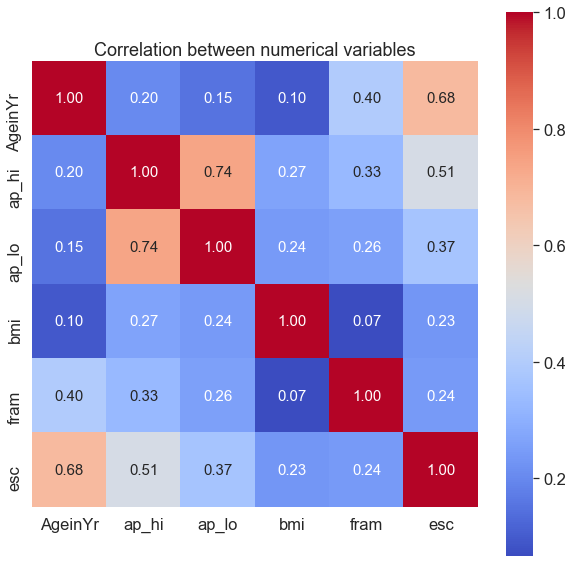

In [117]:
corr = data_numerical.corr()

plt.style.use("seaborn-whitegrid")
sns.set(font_scale = 1.5)

fig4 = plt.figure(figsize = (10,10))

sns.heatmap(corr, cbar = True,  square = True, annot = True, fmt = '.2f', annot_kws = {'size': 15}, cmap = 'coolwarm')

plt.title("Correlation between numerical variables", fontsize = 18)


plt.show()

fig4.savefig('corr numerical', dpi=300)


**As we can see in this heatmap, among the numerical variables we find a higher degree of correlation between age and both score**

## 2.3 Dummy variables, train/test and standardization

**As we have categorical variables, we need to turn them to dummies variables**

In [12]:
categoricals = ["gender", "cholesterol", "gluc", "smoke", "alco", "active"]

enc = OneHotEncoder(drop = "first")
X = data[categoricals]
enc.fit(X)
enc.categories_

[array(['f', 'm'], dtype=object),
 array(['bordering', 'high', 'normal'], dtype=object),
 array(['diabetes', 'normal', 'prediabetes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object),
 array(['no', 'yes'], dtype=object)]

In [13]:
dummies = enc.transform(X).toarray()

In [14]:
dummies_df = pd.DataFrame(dummies)

In [15]:
col_names = [categoricals[i] + '_' + enc.categories_[i] for i in range(len(categoricals))] 

In [16]:
col_names_drop_first = [sublist[i] for sublist in col_names for i in range(len(sublist)) if i != 0]

In [17]:
dummies_df.columns = col_names_drop_first

In [18]:
variables_numericas = ["AgeinYr", "ap_hi", "ap_lo", "bmi", "fram", "esc"]
variables_numericas

['AgeinYr', 'ap_hi', 'ap_lo', 'bmi', 'fram', 'esc']

In [19]:
data_numerica = data[variables_numericas]

In [20]:
#We concatenate all of our variables
data_final = pd.concat([dummies_df, data_numerica,data["cardio"]], axis = 1)
data_final.head()

,gender_m,cholesterol_high,cholesterol_normal,gluc_normal,gluc_prediabetes,smoke_yes,alco_yes,active_yes,AgeinYr,ap_hi,ap_lo,bmi,fram,esc,cardio
0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,50,110.0,80.0,21.97,12,2,0
1,1.0,1.0,0.0,1.0,0.0,0.0,0.0,1.0,55,140.0,90.0,34.93,16,10,1
2,1.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,51,130.0,70.0,23.51,13,6,1
3,0.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,48,150.0,100.0,28.71,15,2,1
4,1.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,47,100.0,60.0,23.01,9,2,0


In [21]:
#We draw out our target variable
X = data_final.drop("cardio", axis = 1)
y = data_final["cardio"]

In [22]:
# We separate the training data from the test data
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify = y, test_size = 0.2, random_state = 123)

In [23]:
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(53887, 14)
(13472, 14)
(53887,)
(13472,)


In [24]:
# We standardize the data to obtain a correct regularization
scaler = StandardScaler()
X_train_std = scaler.fit_transform(X_train)
X_test_std = scaler.transform(X_test)

<a id='3'></a>

---

# 3. Logistic Regression

In [25]:
# We instantiate the model
lr = LogisticRegression()

In [26]:
#Model Fitting
lr.fit(X_train_std, y_train)

y_train_pred_lr = lr.predict(X_train_std)
y_test_pred_lr = lr.predict(X_test_std)

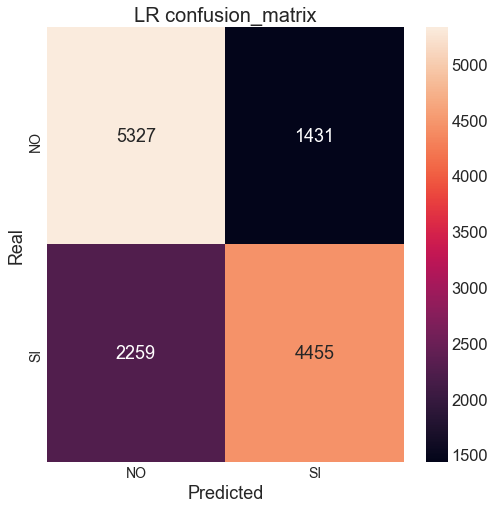

In [27]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (8,8))

sns.heatmap(confusion_matrix(y_test, y_test_pred_lr), annot = True, fmt = '4d')

plt.title("LR confusion_matrix", fontsize = 20)
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel('Real', fontsize = 18)

plt.xticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)
plt.yticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)

plt.show()

**This confusion matrix shows that this model discriminates better true positives, however it has a high false negative rate for our case study.**

In [36]:
#We use predict_proba method to return the class probabilities for each data point.


y_train_pred_proba_lr = lr.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_lr = lr.predict_proba(X_test_std)[:, 1]

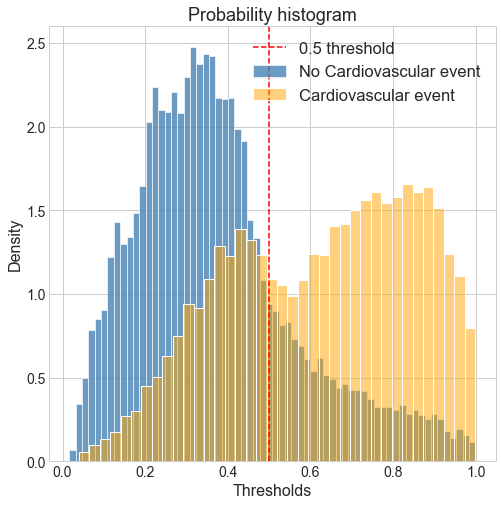

In [37]:
# Probability histogram

plt.figure(figsize = (8,8))

sns.histplot(data = lr.predict_proba(X_train_std[y_train == 0])[:,1], stat = 'density', color = "steelblue", alpha = 0.8)
sns.histplot(data = lr.predict_proba(X_train_std[y_train == 1])[:,1], stat = 'density', color = "orange", alpha = 0.5)

ylim = plt.ylim()
plt.ylim(ylim)

plt.vlines(0.5, ylim[0], ylim[1], linestyle = "--", color = "red")

plt.title("Probability histogram", fontsize = 18)
plt.xlabel("Thresholds", fontsize = 16)
plt.ylabel("Density", fontsize = 16) 

plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

plt.legend(['0.5 threshold', "No Cardiovascular event",  "Cardiovascular event"])

plt.show()

APRECIACION DEL GRAFICO

In [38]:
print("Accuracy:", accuracy_score(y_test, y_test_pred_lr).round(2))
print("F1 Score:", f1_score(y_test, y_test_pred_lr).round(2))
print("precision_score:", precision_score(y_test, y_test_pred_lr).round(2))
print("recall_score:", recall_score(y_test, y_test_pred_lr).round(2))
print("auc_score from train:", roc_auc_score(y_train, y_train_pred_proba_lr).round(3))
print("auc_score from test:", roc_auc_score(y_test, y_test_pred_proba_lr).round(3))

Accuracy: 0.73
F1 Score: 0.71
precision_score: 0.76
recall_score: 0.66
auc_score from train: 0.793
auc_score from test: 0.792


**We have found an appropriate accuracy for the case study, with a not so high recall and an adequate AUC**

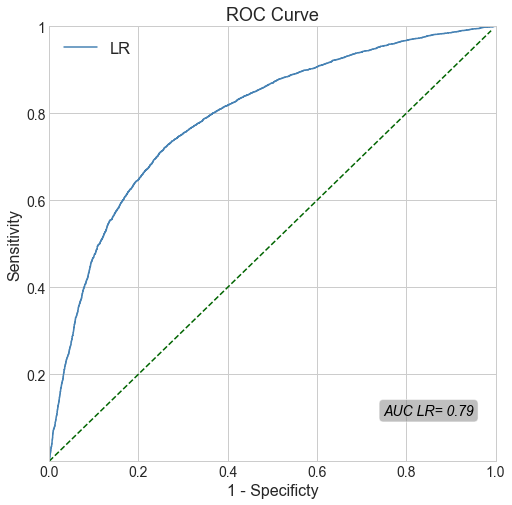

In [39]:
# An ROC curve (receiver operating characteristic curve) is a graph showing 
#the performance of a classification model at all classification thresholds

fpr_lr, tpr_lr, thr_lr = roc_curve(y_test, y_test_pred_proba_lr) 

plt.figure(figsize = (8,8))

plt.plot(fpr_lr, tpr_lr, color = "steelblue", label = "LR")
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = "darkgreen", linestyle = "--")

plt.title('ROC Curve', fontsize = 18) 
plt.xlabel('1 - Specificty', fontsize = 16)
plt.ylabel('Sensitivity', fontsize = 16)

plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

plt.legend('LR') 

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.85, 0.1, f"AUC LR= {round(auc(fpr_lr, tpr_lr),2)}", ha = "center", va = "bottom", **style, bbox = props)

plt.legend()

plt.show()

**An AUC of 0.79 would actually mean that if we take two data points belonging to separate classes then there is 79% chance model would be able to segregate them or rank order them correctly i.e positive point has a higher prediction probability than the negative class**

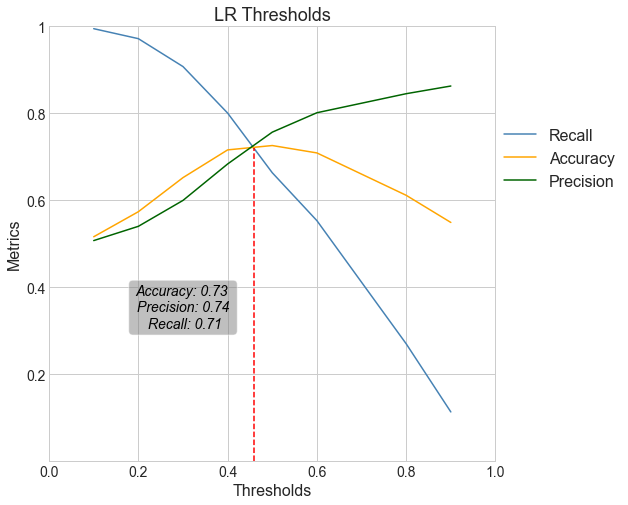

In [98]:
#We tested different thresholds


recalls_lr = []
accuracy_lr = []
precision_lr = []
aucs_lr = []

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]

probs_test_lr = lr.predict_proba(X_test_std)[:,1]

for th in thresholds:
    y_pred_test_umbral_lr = probs_test_lr > th
    rec_lr = recall_score(y_test, y_pred_test_umbral_lr)
    acc_lr = accuracy_score(y_test, y_pred_test_umbral_lr)
    pres_lr = precision_score(y_test, y_pred_test_umbral_lr)    
    
    recalls_lr.append(rec_lr)
    accuracy_lr.append(acc_lr)
    precision_lr.append(pres_lr)
    
plt.figure(figsize = (8,8)) 

# plot the recalls values
plt.plot(thresholds, recalls_lr, color = "steelblue", label = "Recall")
plt.plot(thresholds, accuracy_lr, color = "orange", label = "Accuracy")
plt.plot(thresholds, precision_lr, color = "darkgreen", label = "Precision")

#plt.legend(['recall', 'accuracy', 'precision'])

plt.title("LR Thresholds", fontsize = 18)
plt.xlabel("Thresholds", fontsize = 16)
plt.ylabel("Metrics", fontsize = 16)


plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

umbral_lr = 0.46
y_pred_test_umbral_final_lr = probs_test_lr > umbral_lr

# Scores with a 0.46 Thresholds
accuracy_lr = accuracy_score(y_test, y_pred_test_umbral_final_lr).round(2)
precision_lr = precision_score(y_test, y_pred_test_umbral_final_lr).round(2)
recall_lr = recall_score(y_test, y_pred_test_umbral_final_lr).round(2)

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.3, 0.3, f"Accuracy: {accuracy_lr} \n Precision: {precision_lr} \n Recall: {recall_lr}", ha = "center", va = "bottom", **style, bbox = props)
plt.axvline(0.46, color = "red", linestyle = "--", ymax = 0.72)

plt.legend(fontsize = 16, bbox_to_anchor = (1.3, 0.8))

plt.show() 

**We looked for the threshold that better fit our LR. We have found the same Accuracy but a better Recall**

<a id='4'></a>

---

# 4. Naive Bayes

In [41]:
# We instantiate the model
gnb =  GaussianNB()

In [42]:
#Model Fitting
gnb.fit(X_train_std, y_train)

y_train_pred_gnb = gnb.predict(X_train_std)
y_test_pred_gnb = gnb.predict(X_test_std)

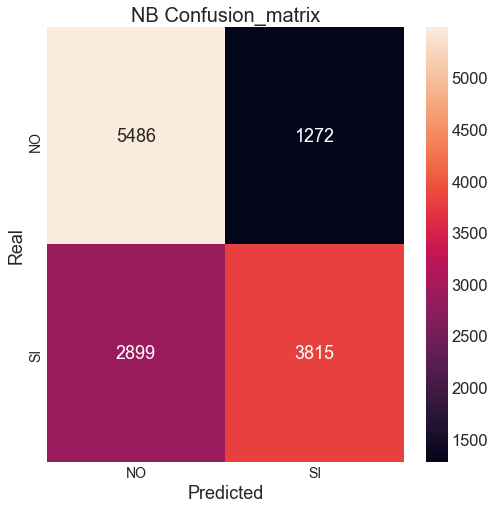

In [99]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (8,8))

sns.heatmap(confusion_matrix(y_test, y_test_pred_gnb), annot = True, fmt = '4d')

plt.title("NB Confusion_matrix", fontsize = 20)
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel('Real', fontsize = 18)

plt.xticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)
plt.yticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)

plt.show()

**This confusion matrix shows that this model discriminates better true negatives that the RL model**

In [44]:
#We use predict_proba method to return the class probabilities for each data point.

y_train_pred_proba_gnb = gnb.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_gnb = gnb.predict_proba(X_test_std)[:, 1]

In [45]:
print("Accuracy:", accuracy_score(y_test, y_test_pred_gnb).round(2))
print("F1 Score:", f1_score(y_test, y_test_pred_gnb).round(2))
print("precision_score:", precision_score(y_test, y_test_pred_gnb).round(2))
print("recall_score:", recall_score(y_test, y_test_pred_gnb).round(2))
print("auc_score from train:", roc_auc_score(y_train, y_train_pred_proba_gnb).round(3))
print("auc_score from test:", roc_auc_score(y_test, y_test_pred_proba_gnb).round(3))

Accuracy: 0.69
F1 Score: 0.65
precision_score: 0.75
recall_score: 0.57
auc_score from train: 0.771
auc_score from test: 0.769


**We have found an lower accuracy than the previous model with a not so high recall and an adequate AUC**

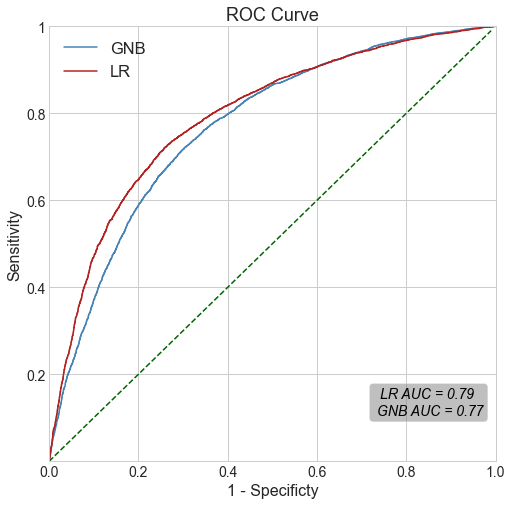

In [46]:
# Getting the GNB model's ROC curve 
fpr_gnb, tpr_gnb, thr_gnb = roc_curve(y_test, y_test_pred_proba_gnb) 

plt.figure(figsize = (8,8))

plt.plot(fpr_gnb, tpr_gnb, color = "steelblue", label = "GNB")
plt.plot(fpr_lr, tpr_lr, color = "firebrick", label = "LR")
plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = "darkgreen", linestyle = "--")

plt.title('ROC Curve', fontsize = 18) 
plt.xlabel('1 - Specificty', fontsize = 16)
plt.ylabel('Sensitivity', fontsize = 16)

plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

plt.legend() 

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.85, 0.1, f"LR AUC = {round(auc(fpr_lr, tpr_lr),2)} \n GNB AUC = {round(auc(fpr_gnb, tpr_gnb),2)}", ha = "center", va = "bottom", **style, bbox = props)

plt.show()

**The ROC curve of the GB model has not improved the ROC curve score of the LR model**

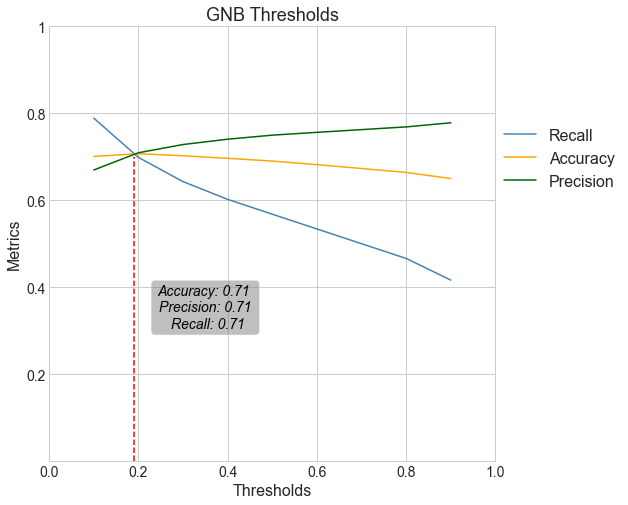

In [100]:
#We tested different thresholds


recalls_gnb = []
accuracy_gnb = []
precision_gnb = []
aucs_gnb = []

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]

probs_test_gnb = gnb.predict_proba(X_test_std)[:,1]

for th in thresholds:
    y_pred_test_umbral_gnb = probs_test_gnb > th
    rec_gnb = recall_score(y_test, y_pred_test_umbral_gnb)
    acc_gnb = accuracy_score(y_test, y_pred_test_umbral_gnb)
    pres_gnb = precision_score(y_test, y_pred_test_umbral_gnb)    
    
    recalls_gnb.append(rec_gnb)
    accuracy_gnb.append(acc_gnb)
    precision_gnb.append(pres_gnb)
    
plt.figure(figsize = (8,8)) 

# plot the recalls values
plt.plot(thresholds, recalls_gnb, color = "steelblue", label = "Recall")
plt.plot(thresholds, accuracy_gnb, color = "orange", label = "Accuracy")
plt.plot(thresholds, precision_gnb, color = "darkgreen", label = "Precision")

#plt.legend(['recall', 'accuracy', 'precision'])

plt.title("GNB Thresholds", fontsize = 18)
plt.xlabel("Thresholds", fontsize = 16)
plt.ylabel("Metrics", fontsize = 16)


plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

# Plotting the thresholds we obtain that 0.19 is the best threshold.
umbral_gnb = 0.19
y_pred_test_umbral_final_gnb = probs_test_gnb > umbral_gnb

# Scores with 0.19 thresholds
accuracy_gnb = accuracy_score(y_test, y_pred_test_umbral_final_gnb).round(2)
precision_gnb = precision_score(y_test, y_pred_test_umbral_final_gnb).round(2)
recall_gnb = recall_score(y_test, y_pred_test_umbral_final_gnb).round(2)

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.35, 0.3, f"Accuracy: {accuracy_gnb} \n Precision: {precision_gnb} \n Recall: {recall_gnb}", ha = "center", va = "bottom", **style, bbox = props)
plt.axvline(0.19, color = "red", linestyle = "--", ymax = 0.7)

plt.legend(fontsize = 16, bbox_to_anchor = (1.3, 0.8))

plt.show() 

<a id='5'></a>

---

# 5. KNN

In [48]:
# We instantiate the model

knn = KNeighborsClassifier(n_neighbors = 100)

In [49]:
#Model Fitting
knn.fit(X_train_std, y_train)

y_train_pred_knn = knn.predict(X_train_std)
y_test_pred_knn = knn.predict(X_test_std)

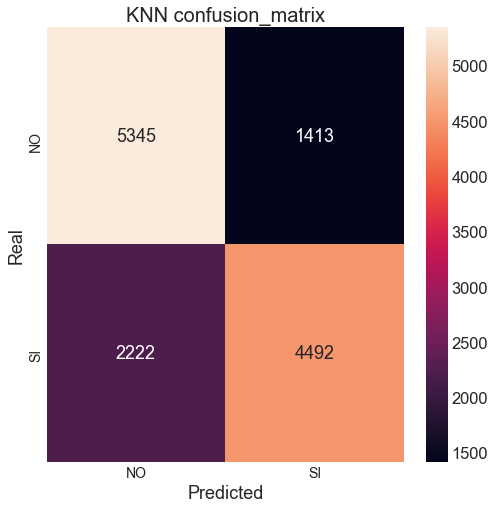

In [101]:
plt.style.use("seaborn-whitegrid")
plt.figure(figsize = (8,8))

sns.heatmap(confusion_matrix(y_test, y_test_pred_knn), annot = True, fmt = '4d')

plt.title("KNN confusion_matrix", fontsize = 20)
plt.xlabel("Predicted", fontsize = 18)
plt.ylabel('Real', fontsize = 18)

plt.xticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)
plt.yticks(ticks = [0.5, 1.5], labels = ["NO", "SI"], fontsize = 14)

plt.show()

In [51]:
#We use predict_proba method to return the class probabilities for each data point.

y_train_pred_proba_knn = knn.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_knn = knn.predict_proba(X_test_std)[:, 1]

In [52]:
print("Accuracy:", accuracy_score(y_test, y_test_pred_knn).round(2))
print("F1 Score:", f1_score(y_test, y_test_pred_knn).round(2))
print("precision_score:", precision_score(y_test, y_test_pred_knn).round(2))
print("recall_score:", recall_score(y_test, y_test_pred_knn).round(2))
print("auc_score from train:", roc_auc_score(y_train, y_train_pred_proba_knn).round(3))
print("auc_score from test:", roc_auc_score(y_test, y_test_pred_proba_knn).round(3))

Accuracy: 0.73
F1 Score: 0.71
precision_score: 0.76
recall_score: 0.67
auc_score from train: 0.803
auc_score from test: 0.794


**The confusion matrix shows that this model discriminates better true positives, however it has a high false negative rate for our case study.**

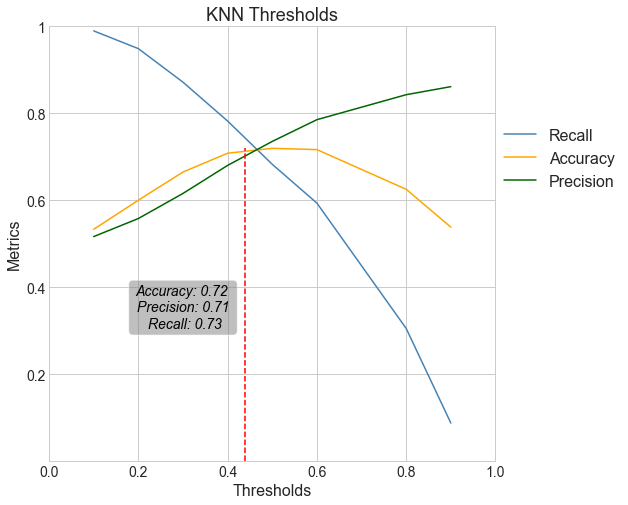

In [102]:
#We tested different thresholds

recalls_knn = []
accuracy_knn = []
precision_knn = []
aucs_knn = []

thresholds = [0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.8, 0.9]

probs_test_knn = knn.predict_proba(X_test_std)[:,1]

for th in thresholds:
    y_pred_test_umbral_knn = probs_test_knn > th
    rec_knn = recall_score(y_test, y_pred_test_umbral_knn)
    acc_knn = accuracy_score(y_test, y_pred_test_umbral_knn)
    pres_knn = precision_score(y_test, y_pred_test_umbral_knn)    
    
    recalls_knn.append(rec_knn)
    accuracy_knn.append(acc_knn)
    precision_knn.append(pres_knn)
    
plt.figure(figsize = (8,8)) 

# plot the recalls values
plt.plot(thresholds, recalls_knn, color = "steelblue", label = "Recall")
plt.plot(thresholds, accuracy_knn, color = "orange", label = "Accuracy")
plt.plot(thresholds, precision_knn, color = "darkgreen", label = "Precision")

#plt.legend(['recall', 'accuracy', 'precision'])

plt.title("KNN Thresholds", fontsize = 18)
plt.xlabel("Thresholds", fontsize = 16)
plt.ylabel("Metrics", fontsize = 16)


plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

#Plotting the thresholds we obtain that 0.44 is the best threshold.

umbral_knn = 0.44
y_pred_test_umbral_final_knn = probs_test_knn > umbral_knn

# Scores with 0.44 threshold
accuracy_knn = accuracy_score(y_test, y_pred_test_umbral_final_knn).round(2)
precision_knn = precision_score(y_test, y_pred_test_umbral_final_knn).round(2)
recall_knn = recall_score(y_test, y_pred_test_umbral_final_knn).round(2)

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.3, 0.3, f"Accuracy: {accuracy_knn} \n Precision: {precision_knn} \n Recall: {recall_knn}", ha = "center", va = "bottom", **style, bbox = props)
plt.axvline(0.44, color = "red", linestyle = "--", ymax = 0.72)

plt.legend(fontsize = 16, bbox_to_anchor = (1.3, 0.8))

plt.show()

<a id='5.1'></a>

## 5.1 K between 1 and 25

In [54]:
start = time.time()

k_range = list(range(1, 20))
auc_train = []
auc_test = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors = k)
    knn.fit(X_train_std, y_train)
    
    y_train_pred_proba_knn = knn.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba_knn = knn.predict_proba(X_test_std)[:, 1]
     
    auc_train.append(roc_auc_score(y_train, y_train_pred_proba_knn))
    auc_test.append(roc_auc_score(y_test, y_test_pred_proba_knn))

end = time.time()
print(end - start) 

116.77866387367249


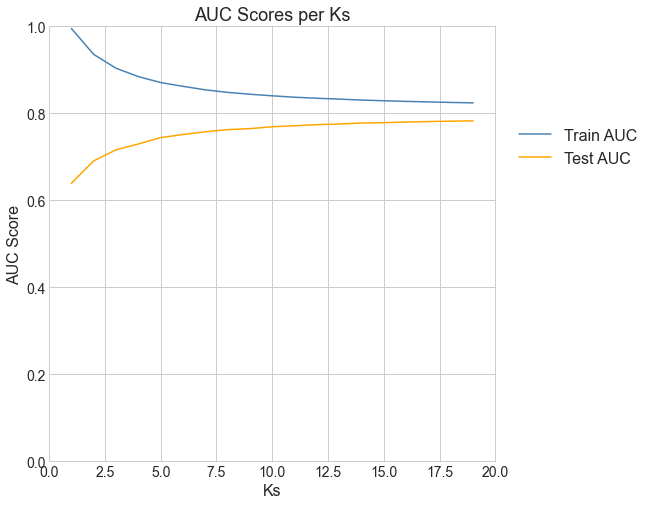

In [104]:
plt.style.use("seaborn-whitegrid")

fig, ax = plt.subplots(figsize = (8, 8))

plt.plot(k_range, auc_train, color = "steelblue", label = "Train AUC")
plt.plot(k_range, auc_test, color = "orange", label = "Test AUC")

plt.title("AUC Scores per Ks", fontsize = 18)
plt.xlabel('Ks', fontsize = 16)
plt.ylabel('AUC Score', fontsize = 16)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)
plt.ylim(0, 1)
plt.xlim(0, 20)

plt.legend(fontsize = 16, bbox_to_anchor = (1.35, 0.8))

plt.show()

In [105]:
l =  [i for i, val in enumerate(auc_train) if val == max(auc_train)]
print('Minimum K of all those with maximum AUC score: ', min(l) + 1)
print('Maximum K of all those with maximum AUC score: ', max(l) + 1)
print("AUC train:", auc_train)

Minimum K of all those with maximum AUC score:  1
Maximum K of all those with maximum AUC score  1
AUC train: [0.9952507450497069, 0.9356221509052607, 0.90383823683568, 0.884590128859246, 0.8709253619998019, 0.8622168219263998, 0.8541904617123854, 0.8482955766701082, 0.8440541396886627, 0.8404356603824948, 0.837182802850812, 0.834875821072425, 0.8328414153472753, 0.8306753039037373, 0.8290567159611177, 0.8275940119043478, 0.8264046780390066, 0.8251892891401394, 0.8242090870562276]


In [106]:
l =  [i for i, val in enumerate(auc_test) if val == max(auc_test)]
print('Minimum K of all those with maximum AUC score: ', min(l) + 1)
print('Maximum K of all those with maximum AUC score: ', max(l) + 1)
print("AUC test:", auc_test)

Minimum K of all those with maximum AUC score:  19
Maximum K of all those with maximum AUC score:  19
AUC test: [0.6393199802561916, 0.690876083447652, 0.7163288880672589, 0.7297344521256287, 0.7443607474824573, 0.7514281885091141, 0.7577285910461883, 0.7626545923175991, 0.7649832791207287, 0.7692983913063065, 0.7715161315888326, 0.774096861381557, 0.7756236322877031, 0.7778883386082518, 0.7786269131662973, 0.7800951142713898, 0.7812868086129763, 0.7821076894446, 0.7828658460414926]


**We will go with K = 19**

<a id='5.2'></a>

## 5.2 GridSearchCV

In [58]:
grid_params = {"n_neighbors": [5,10,15,20,25],
               "weights": ["uniform", "distance"],
               "metric": ["euclidean", "manhattan"]}

In [59]:
gs_knn = GridSearchCV(KNeighborsClassifier(), grid_params, verbose = 1, cv = 3, n_jobs = -1, scoring = "roc_auc")

In [60]:
start = time.time()

gs_knn.fit(X_train_std, y_train)

end = time.time()
print(end - start) 

Fitting 3 folds for each of 20 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   54.9s finished


55.16827416419983


In [61]:
gs_knn.best_score_

0.7860420600480892

In [62]:
gs_knn.best_params_

{'metric': 'euclidean', 'n_neighbors': 25, 'weights': 'uniform'}

In [63]:
gs_knn.best_estimator_

KNeighborsClassifier(metric='euclidean', n_neighbors=25)

In [64]:
best_model_knn = gs_knn.best_estimator_

In [65]:
y_train_pred_proba_knn = best_model_knn.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_knn = best_model_knn.predict_proba(X_test_std)[:, 1]

train_roc_auc_knn = roc_auc_score(y_train, y_train_pred_proba_knn)
test_roc_auc_knn = roc_auc_score(y_test, y_test_pred_proba_knn)

print('Train set ROC AUC score: {:.3f}'.format(train_roc_auc_knn))
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_knn))

Train set ROC AUC score: 0.819
Test set ROC AUC score: 0.787


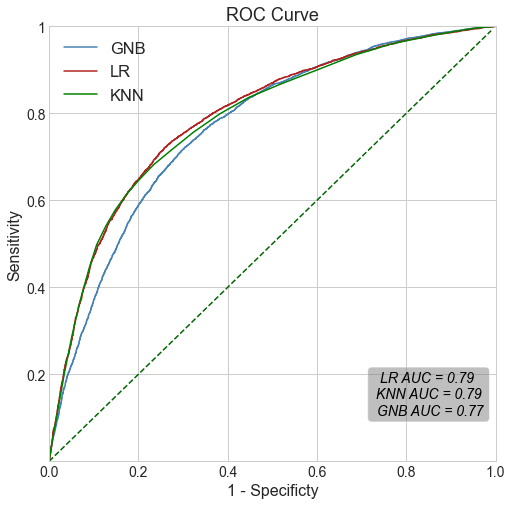

In [107]:
#We tested different thresholds
fpr_gnb, tpr_gnb, thr_gnb = roc_curve(y_test, y_test_pred_proba_gnb)
fpr_lr, tpr_lr, thr_lr = roc_curve(y_test, y_test_pred_proba_lr)
fpr_knn, tpr_knn, thr_knn = roc_curve(y_test, y_test_pred_proba_knn)

plt.figure(figsize = (8,8))

plt.plot(fpr_gnb, tpr_gnb, color = "steelblue", label = "GNB")
plt.plot(fpr_lr, tpr_lr, color = "firebrick", label = "LR")
plt.plot(fpr_knn, tpr_knn, color = "green", label = "KNN")

plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = "darkgreen", linestyle = "--")

plt.title('ROC Curve', fontsize = 18) 
plt.xlabel('1 - Specificty', fontsize = 16)
plt.ylabel('Sensitivity', fontsize = 16)

plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

plt.legend() 

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.85, 0.1, f"LR AUC = {round(auc(fpr_lr, tpr_lr),2)} \n KNN AUC = {round(auc(fpr_knn, tpr_knn),2)} \n GNB AUC = {round(auc(fpr_gnb, tpr_gnb),2)}", ha = "center", va = "bottom", **style, bbox = props)

plt.show()

<a id='6'></a>

---

# 6. RANDOM FOREST

<a id='6.1'></a>

## 6.1 Generating validation curves

<a id='6.1.A'></a>

### A. n_estimators

In [67]:
param_range = [10, 100, 500, 1000, 1500]

In [68]:
start = time.time()


eje_x = []
eje_y_train = []
eje_y_test = []

for i in param_range:    
    # We instantiate the model

    rf_clf = RandomForestClassifier(n_estimators = i)
    
    # Fitting
    rf_clf.fit(X_train_std, y_train)
    
    # Predicting
    y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

    # ROC
    train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
    test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
    
    # Appending
    eje_x.append(i)
    eje_y_train.append(train_roc_auc_rf)
    eje_y_test.append(test_roc_auc_rf)
    
end = time.time()
print(end - start)

161.5104899406433


In [69]:
eje_y_test

[0.7431039817062104,
 0.7612034276965007,
 0.761649924629537,
 0.762157305504402,
 0.7621920616949049]

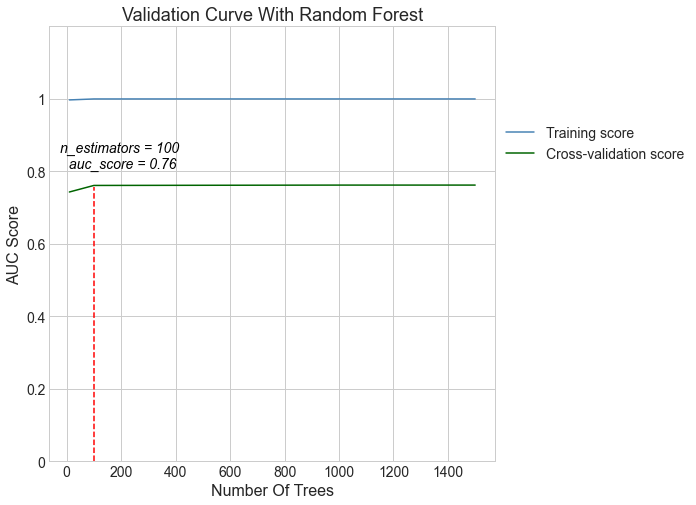

In [70]:
plt.style.use("seaborn-whitegrid")

plt.subplots(1, figsize=(8,8))

plt.plot(eje_x, eje_y_train, label = "Training score", color = "steelblue")
plt.plot(eje_x, eje_y_test, label = "Cross-validation score", color = "darkgreen")

plt.title("Validation Curve With Random Forest", fontsize = 18)
plt.xlabel("Number Of Trees", fontsize = 16)
plt.ylabel("AUC Score", fontsize = 16)

plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14) 
plt.xticks(fontsize = 14)
plt.ylim(0, 1.2)

plt.axvline(100, color = "red", linestyle = "--", ymax = 0.63)
style = dict(size = 14, color = 'black', fontstyle = "oblique")
plt.text(200, 0.8, f"n_estimators = 100 \n auc_score = {eje_y_test[1].round(2)}", ha = "center", va = "bottom", **style)


plt.legend(fontsize = 14, bbox_to_anchor = (1.45, 0.8))

plt.show()

**From 100 trees onwards it makes no sense to increase**

<a id='6.1.B'></a>

### B. max_depth

In [71]:
max_depth = [10,20,30,40,50,60,70,80,90,100]

In [72]:
start = time.time()

# Creo ejes del gráfico

eje_x = []
eje_y_train = []
eje_y_test = []

for i in max_depth:    
    # We instantiate the model
    rf_clf = RandomForestClassifier(max_depth = i)
    
    # Fitting
    rf_clf.fit(X_train_std, y_train)
    
    # Predicting
    y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

    # ROC
    train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
    test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
    
    # Appending
    eje_x.append(i)
    eje_y_train.append(train_roc_auc_rf)
    eje_y_test.append(test_roc_auc_rf)
    
end = time.time()
print(end - start)

47.6676242351532


In [73]:
eje_y_test

[0.8009974365491249,
 0.7882431157838241,
 0.7666758416838553,
 0.7610249303046916,
 0.7609190418346402,
 0.7596167205442717,
 0.7596527109431883,
 0.7598348448419301,
 0.7609224138683415,
 0.7609972377534128]

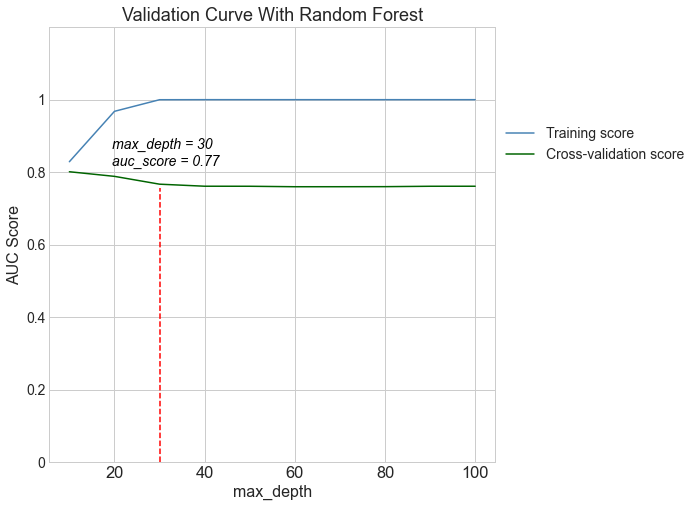

In [74]:
plt.style.use("seaborn-whitegrid")

plt.subplots(1, figsize=(8,8))

plt.plot(eje_x, eje_y_train, label = "Training score", color = "steelblue")
plt.plot(eje_x, eje_y_test, label = "Cross-validation score", color = "darkgreen")

plt.title("Validation Curve With Random Forest", fontsize = 18)
plt.xlabel("max_depth", fontsize = 16)
plt.ylabel("AUC Score", fontsize = 16)

plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14) 
plt.ylim(0, 1.2)

plt.axvline(30, color = "red", linestyle = "--", ymax = 0.63)
style = dict(size = 14, color = 'black', fontstyle = "oblique")
plt.text(31, 0.81, f"max_depth = 30 \n auc_score = {eje_y_test[2].round(2)}", ha = "center", va = "bottom", **style)


plt.legend(fontsize = 14, bbox_to_anchor = (1.45, 0.8))

plt.show()

**From 25/30  onwards it makes no sense to increase depth, we choose 25**

<a id='6.1.C'></a>

### C. min_samples_split

In [75]:
min_samples_split = [2, 5, 10, 15, 20, 25, 30, 35, 40, 45, 50]

In [76]:
start = time.time()

# Creo ejes del gráfico

eje_x = []
eje_y_train = []
eje_y_test = []

for i in min_samples_split:    
    #We instantiate the model

    rf_clf = RandomForestClassifier(min_samples_split = i)
    
    # Fitting
    rf_clf.fit(X_train_std, y_train)
    
    # Predicting
    y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

    # ROC
    train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
    test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
    
    # Appending
    eje_x.append(i)
    eje_y_train.append(train_roc_auc_rf)
    eje_y_test.append(test_roc_auc_rf)
    
end = time.time()
print(end - start)

44.35697102546692


In [77]:
eje_y_test

[0.7594751392076893,
 0.7758929211359336,
 0.7868824450867618,
 0.7910018140218947,
 0.7928661299094277,
 0.7953098956274024,
 0.7965838962425671,
 0.7966332205002369,
 0.7973477059547823,
 0.7977781691981605,
 0.798171650268004]

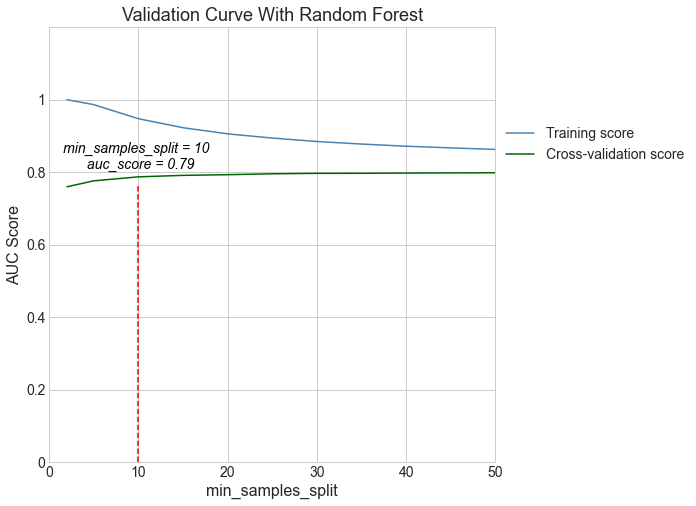

In [78]:
plt.style.use("seaborn-whitegrid")

plt.subplots(1, figsize=(8,8))

plt.plot(eje_x, eje_y_train, label = "Training score", color = "steelblue")
plt.plot(eje_x, eje_y_test, label = "Cross-validation score", color = "darkgreen")

plt.title("Validation Curve With Random Forest", fontsize = 18)
plt.xlabel("min_samples_split", fontsize = 16)
plt.ylabel("AUC Score", fontsize = 16)

plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14) 
plt.xticks(fontsize = 14)
plt.ylim(0, 1.2)
plt.xlim(0,50)

plt.axvline(10, color = "red", linestyle = "--", ymax = 0.64)
style = dict(size = 14, color = 'black', fontstyle = "oblique")
plt.text(10, 0.8, f"min_samples_split = 10 \n auc_score = {eje_y_test[2].round(2)}", ha = "center", va = "bottom", **style)


plt.legend(fontsize = 14, bbox_to_anchor = (1.45, 0.8))

plt.show()

**min_samples_split = 10**

<a id='6.1.D'></a>

### D. min_samples_leaf

In [79]:
min_samples_leaf = [1, 2, 4, 6, 8, 10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30]

In [80]:
start = time.time()



eje_x = []
eje_y_train = []
eje_y_test = []

for i in min_samples_leaf:    
    #We instantiate the model
    rf_clf = RandomForestClassifier(min_samples_leaf = i)
    
    # Fitting
    rf_clf.fit(X_train_std, y_train)
    
    # Predicting
    y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
    y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

    # ROC
    train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
    test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)
    
    # Appending
    eje_x.append(i)
    eje_y_train.append(train_roc_auc_rf)
    eje_y_test.append(test_roc_auc_rf)
    
end = time.time()
print(end - start)

52.750850677490234


In [81]:
eje_y_test

[0.7591487351611784,
 0.7881340095561231,
 0.7969606824396739,
 0.7986919131931854,
 0.7992114267775444,
 0.7996281484326039,
 0.8001961928549383,
 0.8004574593484808,
 0.8005538378019171,
 0.8007406991596716,
 0.800836019720182,
 0.800710273718334,
 0.8006144021719247,
 0.800625829619468,
 0.8008869859158307,
 0.8004233423016205]

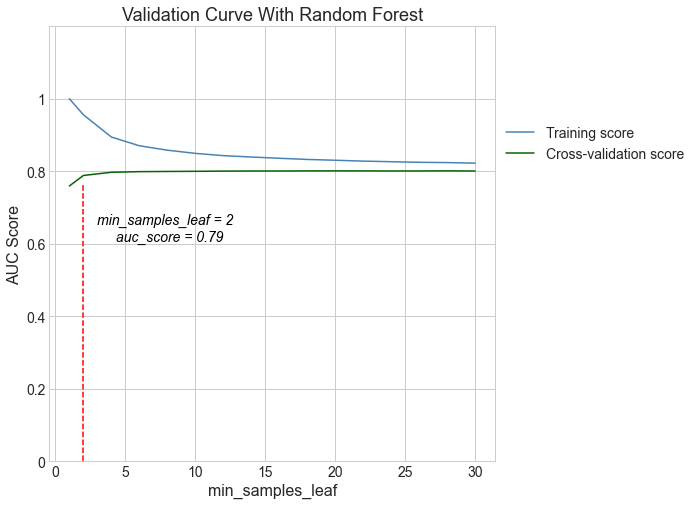

In [82]:
plt.style.use("seaborn-whitegrid")

plt.subplots(1, figsize=(8,8))

plt.plot(eje_x, eje_y_train, label = "Training score", color = "steelblue")
plt.plot(eje_x, eje_y_test, label = "Cross-validation score", color = "darkgreen")

plt.title("Validation Curve With Random Forest", fontsize = 18)
plt.xlabel("min_samples_leaf", fontsize = 16)
plt.ylabel("AUC Score", fontsize = 16)

plt.yticks(ticks = [0, 0.2, 0.4, 0.6, 0.8, 1], labels = [0, 0.2, 0.4, 0.6, 0.8, 1], fontsize = 14) 
plt.xticks(fontsize = 14)
plt.ylim(0, 1.2)

plt.axvline(2, color = "red", linestyle = "--", ymax = 0.64)
style = dict(size = 14, color = 'black', fontstyle = "oblique")
plt.text(8, 0.6, f"min_samples_leaf = 2 \n auc_score = {eje_y_test[1].round(2)}", ha = "center", va = "bottom", **style)


plt.legend(fontsize = 14, bbox_to_anchor = (1.45, 0.8))

plt.show()

We choose 2

<a id='6.1.E'></a>

### E. All combined

**First we try with auto**

In [83]:
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_split = 10, min_samples_leaf = 2, max_features = "auto")

In [84]:
start = time.time()

# Fitting
rf_clf.fit(X_train_std, y_train)

end = time.time()
print(end - start)

2.9274978637695312


In [85]:
# Predicting
y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

In [86]:
# ROC
train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)

print("Train:", train_roc_auc_rf)
print("Test:", test_roc_auc_rf)

Train: 0.9151860831360724
Test: 0.7936038559491887


**We try with sqrt**

In [87]:
rf_clf = RandomForestClassifier(n_estimators = 100, max_depth = 25, min_samples_split = 10, min_samples_leaf = 2, max_features = "sqrt")

In [88]:
# Fitting
rf_clf.fit(X_train_std, y_train)

RandomForestClassifier(max_depth=25, max_features='sqrt', min_samples_leaf=2,
                       min_samples_split=10)

In [89]:
# Predicting
y_train_pred_proba_rf = rf_clf.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_rf = rf_clf.predict_proba(X_test_std)[:, 1]

In [90]:
# ROC
train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)

print("Train:", train_roc_auc_rf)
print("Test:", test_roc_auc_rf)

Train: 0.9150062359753163
Test: 0.7929341876876603


**We get almost the same results**

<a id='6.2'></a>

## 6.2 RandomSearch

In [91]:
# Number of trees in random forest
n_estimators = [int(x) for x in np.linspace(start = 10, stop = 200, num = 10)]

# Number of features to consider at every split
max_features = ['auto', 'sqrt']

# Maximum number of levels in tree
max_depth = [int(x) for x in np.linspace(10, 80, num = 11)]
#max_depth.append(None)

# Minimum number of samples required to split a node
min_samples_split = [2, 5, 10, 20, 40]

# Minimum number of samples required at each leaf node
min_samples_leaf = [2, 4, 6, 8, 10]

# Method of selecting samples for training each tree
bootstrap = [True, False]

# Create the random grid
random_grid = {'n_estimators': n_estimators,
               'max_features': max_features,
               'max_depth': max_depth,
               'min_samples_split': min_samples_split,
               'min_samples_leaf': min_samples_leaf,
               'bootstrap': bootstrap}

In [92]:
start = time.time()

# Use the random grid to search for best hyperparameters
# First create the base model to tune
rf = RandomForestClassifier()
# Random search of parameters, using 3 fold cross validation, 
# search across 100 different combinations, and use all available cores
rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 30, cv = 3, verbose=2, random_state=42, n_jobs = -1, scoring = "roc_auc")
# Fit the random search model
rf_random.fit(X_train_std, y_train)

end = time.time()
print(end - start)

Fitting 3 folds for each of 30 candidates, totalling 90 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   10.6s
[Parallel(n_jobs=-1)]: Done  90 out of  90 | elapsed:   53.6s finished


56.26443815231323


In [93]:
rf_random.best_params_ 

{'n_estimators': 136,
 'min_samples_split': 5,
 'min_samples_leaf': 10,
 'max_features': 'sqrt',
 'max_depth': 10,
 'bootstrap': True}

In [94]:
best_model_rf = rf_random.best_estimator_
best_model_rf

RandomForestClassifier(max_depth=10, max_features='sqrt', min_samples_leaf=10,
                       min_samples_split=5, n_estimators=136)

In [95]:
y_train_pred_proba_rf = best_model_rf.predict_proba(X_train_std)[:, 1]
y_test_pred_proba_rf = best_model_rf.predict_proba(X_test_std)[:, 1]

train_roc_auc_rf = roc_auc_score(y_train, y_train_pred_proba_rf)
test_roc_auc_rf = roc_auc_score(y_test, y_test_pred_proba_rf)

print('Train set ROC AUC score: {:.3f}'.format(train_roc_auc_rf))
print('Test set ROC AUC score: {:.3f}'.format(test_roc_auc_rf))

Train set ROC AUC score: 0.820
Test set ROC AUC score: 0.801


**We choose RandomSearch**

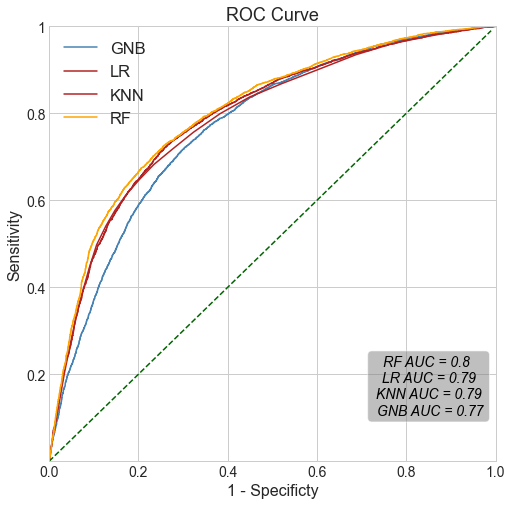

In [116]:
#We tested different thresholds

fpr_rf, tpr_rf, thr_rf = roc_curve(y_test, y_test_pred_proba_rf)
fpr_lr, tpr_lr, thr_lr = roc_curve(y_test, y_test_pred_proba_lr)
fpr_gnb, tpr_gnb, thr_gnb = roc_curve(y_test, y_test_pred_proba_gnb) 
fpr_knn, tpr_knn, thr_knn = roc_curve(y_test, y_test_pred_proba_knn)

fig1  = plt.figure(figsize = (8,8))
plt.plot(fpr_gnb, tpr_gnb, color = "steelblue", label = "GNB")
plt.plot(fpr_lr, tpr_lr, color = "firebrick", label = "LR")
plt.plot(fpr_knn, tpr_knn, color = "firebrick", label = "KNN")
plt.plot(fpr_rf, tpr_rf, color = "orange", label = "RF")

plt.plot(np.arange(0,1, step =0.01), np.arange(0,1, step =0.01), color = "darkgreen", linestyle = "--")

plt.title('ROC Curve', fontsize = 18) 
plt.xlabel('1 - Specificty', fontsize = 16)
plt.ylabel('Sensitivity', fontsize = 16)

plt.ylim(0,1)
plt.xlim(0,1)
plt.yticks(ticks = [0,0.2,0.4,0.6,0.8,1], labels = ["",0.2,0.4,0.6,0.8,1], fontsize = 14)
plt.xticks(fontsize = 14)

plt.legend() 

style = dict(size = 14, color = 'black', fontstyle = "oblique")
props = dict(boxstyle = 'round', facecolor = 'grey', alpha=0.5)

plt.text(0.85, 0.1, f"RF AUC = {round(auc(fpr_rf, tpr_rf),2)} \n LR AUC = {round(auc(fpr_lr, tpr_lr),2)} \n KNN AUC = {round(auc(fpr_knn, tpr_knn),2)} \n GNB AUC = {round(auc(fpr_gnb, tpr_gnb),2)}", ha = "center", va = "bottom", **style, bbox = props)

plt.show()

fig1.savefig("Plot generated using Matplotlib.png")



<a id='7'></a>

---

# 7. Conclusion

#### As we described before, the ROC curve is an evaluation metric for binary classification problems. It is a probability curve that plots the TPR against FPR at various threshold values and essentially separates the ‘signal’ from the ‘noise’. The Area Under the Curve (AUC) is the measure of the ability of a classifier to distinguish between classes and is used as a summary of the ROC curve.  The higher the AUC, the better the performance of the model at distinguishing between the positive and negative classes.

#### It is evident from the plot that the AUC for the Random Forest ROC curve is higher than ROC curves of other models. Therefore, we can say that Random Forest did a better job of classifying the event in out dataset. 


#### In general, AUC values are interpreted as follows: 0.5-0.6 (failed), 0.6-0.7 (worthless), 0.7-0.8 (poor), 0.8-0.9 (good), > 0.9 (excellent) (Metz CE. Basic principles of ROC analysis. Semin Nucl Med. 1978). Therefore, we have a good, but not excellent, classification model.